#Maximum common substructure analysis

## Compound clustering

Clustering consists on grouping the compounds according to its similarity based on a prefered fingerprint architecture. Similarity computation based on Tanimoto indexes ranges from zero (no similarity) to one (high similarity, sometimes identity).

Herein we implemented the [Butina clustering method](https://doi.org/10.1021/ci9803381), developed to identify smaller and homogeneous clusters.

### Preparing the environment

In [ ]:
# this cell have to be run in Colab
# !pip install rdkit

In [ ]:
import random
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys, AllChem
from rdkit.Chem import rdFMCS
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors

### Import and prepare data

In [ ]:
# this is the route to import in Colab
"""
foodb = pd.read_csv(
    "https://raw.githubusercontent.com/DIFACQUIM/Food_chemicals_characterization/main/foodb_curated.csv", index_col = 0
                    )
"""
# route to run in local
fda = pd.read_csv("fda_curated_chiral.csv")


In [ ]:
print(f'dataframe shape: {fda.shape}')
print(fda.head())

dataframe shape: (2324, 8)
        ID DATABASE_NAME                DRUG_GROUPS  GENERIC_NAME  \
0  DB00006      drugbank  approved; investigational   Bivalirudin   
1  DB00007      drugbank  approved; investigational    Leuprolide   
2  DB00014      drugbank                   approved     Goserelin   
3  DB00027      drugbank                   approved  Gramicidin D   
4  DB00035      drugbank                   approved  Desmopressin   

                                            SYNONYMS  \
0           Bivalirudin; Bivalirudina; Bivalirudinum   
1  Leuprorelin; Leuprorelina; Leuproreline; Leupr...   
2                              Goserelin; Goserelina   
3  Bacillus brevis gramicidin D; Gramicidin; Gram...   
4  1-(3-mercaptopropionic acid)-8-D-arginine-vaso...   

                                              SMILES  \
0  CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...   
1  CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...   
2  CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H... 

In [ ]:
fda = fda.drop_duplicates(subset='SMILES_no_chiral', keep='first')

In [ ]:
fda = fda[['ID', 'SMILES_no_chiral']]

In [ ]:
# this cell is to select a random sample of the database to make a minor example
"""
foodb = foodb.sample(n = 2000, random_state = 15)
foodb.reset_index(drop = True, inplace = True)
"""

'\nfoodb = foodb.sample(n = 2000, random_state = 15)\nfoodb.reset_index(drop = True, inplace = True)\n'

In [ ]:
PandasTools.AddMoleculeColumnToFrame(fda, "SMILES_no_chiral")

In [ ]:
fda["MW"] = fda["ROMol"].apply(Descriptors.ExactMolWt)

In [ ]:
fda = fda.drop(fda[fda['MW'] > 1000].index)
fda = fda.reset_index(drop=True)

In [ ]:
print(f'dataframe shape: {fda.shape}')
print(fda.head())

dataframe shape: (2252, 4)
        ID                                   SMILES_no_chiral  \
0  DB00114                   Cc1ncc(CO[PH](=O)(=O)O)c(C=O)c1O   
1  DB00118  C[S+](CCC(N)C(=O)[O-])CC1OC(n2cnc3c(=N)[nH]cnc...   
2  DB00119                                       CC(=O)C(=O)O   
3  DB00120                                NC(Cc1ccccc1)C(=O)O   
4  DB00121                         O=C(O)CCCCC1SCC2NC(=O)NC21   

                                               ROMol          MW  
0  <img data-content="rdkit/molecule" src="data:i...  247.024574  
1  <img data-content="rdkit/molecule" src="data:i...  398.137239  
2  <img data-content="rdkit/molecule" src="data:i...   88.016044  
3  <img data-content="rdkit/molecule" src="data:i...  165.078979  
4  <img data-content="rdkit/molecule" src="data:i...  244.088163  


In [ ]:
# this cell generates an array of molecules and ID for each chiral smiles in foodb
fda_compounds = []
for _, ID, SMILES_no_chiral in fda[['ID', 'SMILES_no_chiral']].itertuples():
  fda_compounds.append((Chem.MolFromSmiles(SMILES_no_chiral), ID))

In [ ]:
fda_compounds[:5]

[(<rdkit.Chem.rdchem.Mol at 0x1507ef697990>, 'DB00114'),
 (<rdkit.Chem.rdchem.Mol at 0x1507ef697da0>, 'DB00118'),
 (<rdkit.Chem.rdchem.Mol at 0x1507ef697d50>, 'DB00119'),
 (<rdkit.Chem.rdchem.Mol at 0x1507ef697ee0>, 'DB00120'),
 (<rdkit.Chem.rdchem.Mol at 0x1507ef697df0>, 'DB00121')]

In [ ]:
# this cell computes the Morgan fingerprint of radius = 2 for each molecule in foodb_compounds array (13 seg)
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits = 1024) for mol, idx in fda_compounds]

In [ ]:
print(f'Number of fingerprints created: {len(fingerprints)}')
print(f'fingerprint length per compound: {len(fingerprints[0])}')

Number of fingerprints created: 2252
fingerprint length per compound: 1024


### Computation of Tanimoto similarity and similarity matrix

In [ ]:
def dissimmat(fp_list):
  """  This function calculates the dissimilarity matrix for the list of fingerprints provided"""
  dissimilarity_matrix = []
  for i in range(1, len(fp_list)):
    # compute similarity of Tanimoto of a molecule with all others in list
    similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
    # 1-similarity consists on the dissimilarity matrix
    dissimilarity_matrix.extend([1 - x for x in similarities])
  return dissimilarity_matrix

In [ ]:
# here an example of how Tanimoto similarity works between two molecules
sim = DataStructs.TanimotoSimilarity(fingerprints[0], fingerprints[1])
print(f"Tanimoto similarity: {sim:.4f}, distance: {1-sim:.4f}")

Tanimoto similarity: 0.1205, distance: 0.8795


### Clustering molecules

In [ ]:
# this cell defines the clustering function based on the Tanimoto distance
# according to the ECFP4 fingerprint
def cluster_fingerprints(fps, cutoff):
  # calculate Tanimoto distance matrix
  distance_matrix = dissimmat(fps)
  # cluster molecules with Butina algorithm
  clusters = Butina.ClusterData(distance_matrix, len(fps), cutoff, isDistData = True)
  clusters = sorted(clusters, key = len, reverse = True)
  return clusters

In [ ]:
clusters = cluster_fingerprints(fingerprints, cutoff=0.05)

In [ ]:
cluster_n1 = sum(1 for c in clusters if len(c) == 1)
cluster_n5 = sum(1 for c in clusters if len(c) > 5)
cluster_n25 = sum(1 for c in clusters if len(c) > 25)
cluster_n100 = sum(1 for c in clusters if len(c) > 100)

In [ ]:
print(f"Total clusters generated: {len(clusters)}")
print("# clusters with only 1 compound: ", cluster_n1)
print("# clusters with > 5 compounds: ", cluster_n5)
print("# clusters with > 25 compounds: ", cluster_n25)
print("# clusters with > 100 compounds: ", cluster_n100)

Total clusters generated: 2233
# clusters with only 1 compound:  2218
# clusters with > 5 compounds:  0
# clusters with > 25 compounds:  0
# clusters with > 100 compounds:  0


<BarContainer object of 2233 artists>

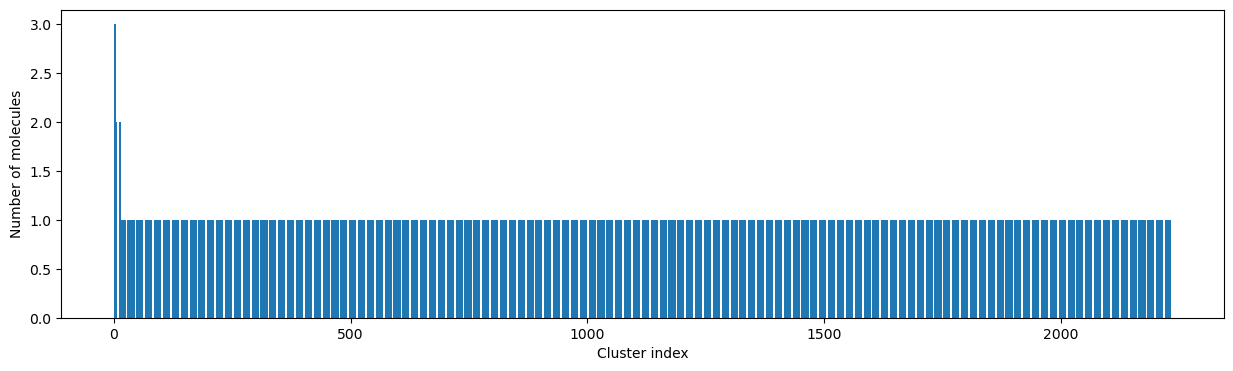

In [ ]:
# plot the size of the clusters
fig, ax = plt.subplots(figsize = (15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw = 5)

In [ ]:
"""# this cell performs a test to define the best cutoff for the clustering
for cutoff in np.arange(0.0, 1.0, 0.1):
  clusters = cluster_fingerprints(fingerprints, cutoff = cutoff)
  fig, ax = plt.subplots(figsize = (15, 4))
  ax.set_title(f"Threshold: {cutoff:3.1f}")
  ax.set_xlabel('Cluster index')
  ax.set_ylabel('Number of molecules')
  ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw = 5)
  display(fig)"""

'# this cell performs a test to define the best cutoff for the clustering\nfor cutoff in np.arange(0.0, 1.0, 0.1):\n  clusters = cluster_fingerprints(fingerprints, cutoff = cutoff)\n  fig, ax = plt.subplots(figsize = (15, 4))\n  ax.set_title(f"Threshold: {cutoff:3.1f}")\n  ax.set_xlabel(\'Cluster index\')\n  ax.set_ylabel(\'Number of molecules\')\n  ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw = 5)\n  display(fig)'

In [ ]:
"""cutoff = 0.05
clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)

# Plot the size of the clusters - save plot
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("# molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters])
ax.set_title(f"Threshold: {cutoff:3.2f}")
    fig.savefig(
    DATA / f"cluster_dist_cutoff_{cutoff:4.2f}.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True)

print(
    f"Number of clusters: {len(clusters)} from {len(foodb_compounds)} molecules at distance cut-off {cutoff:.2f}"
)
print("Number of molecules in largest cluster:", len(clusters[0]))
print(
    f"Similarity between two random points in same cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[0][1]]):.2f}"
)
print(
    f"Similarity between two random points in different cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[1][0]]):.2f}"
)"""

'cutoff = 0.05\nclusters = cluster_fingerprints(fingerprints, cutoff=cutoff)\n\n# Plot the size of the clusters - save plot\nfig, ax = plt.subplots(figsize=(15, 4))\nax.set_xlabel("Cluster index")\nax.set_ylabel("# molecules")\nax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters])\nax.set_title(f"Threshold: {cutoff:3.2f}")\n    fig.savefig(\n    DATA / f"cluster_dist_cutoff_{cutoff:4.2f}.png",\n    dpi=300,\n    bbox_inches="tight",\n    transparent=True)\n\nprint(\n    f"Number of clusters: {len(clusters)} from {len(foodb_compounds)} molecules at distance cut-off {cutoff:.2f}"\n)\nprint("Number of molecules in largest cluster:", len(clusters[0]))\nprint(\n    f"Similarity between two random points in same cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[0][1]]):.2f}"\n)\nprint(\n    f"Similarity between two random points in different cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[1][0]]

### Visualizing the clusters

Ten molecules from the largest cluster: 


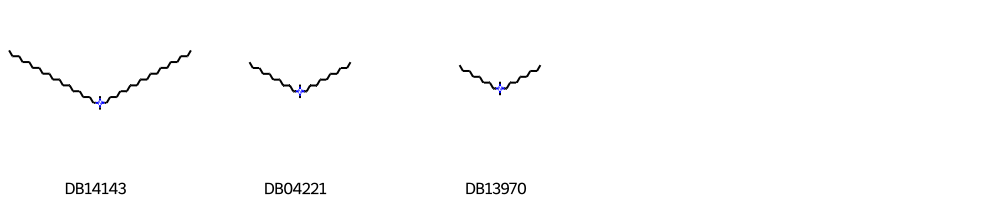

In [ ]:
print("Ten molecules from the largest cluster: ")
# the following steps draw molecules from the largest cluster
Draw.MolsToGridImage(
    [fda_compounds[i][0] for i in clusters[0][:10]],
    legends=[fda_compounds[i][1] for i in clusters[0][:10]],
    molsPerRow = 5,
)

Ten molecules from the second largest cluster: 


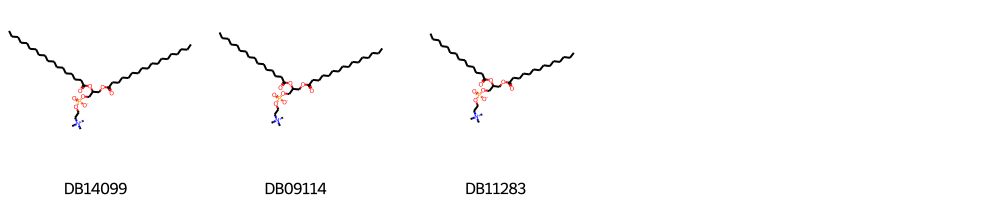

In [ ]:
print("Ten molecules from the second largest cluster: ")
# the following steps draw molecules from the largest cluster
Draw.MolsToGridImage(
    [fda_compounds[i][0] for i in clusters[1][:10]],
    legends=[fda_compounds[i][1] for i in clusters[1][:10]],
    molsPerRow = 5,
)

MCS1 contains 19 atoms and 18 bonds.
MCS SMARTS string: [#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#7](-[#6])(-[#6])-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]


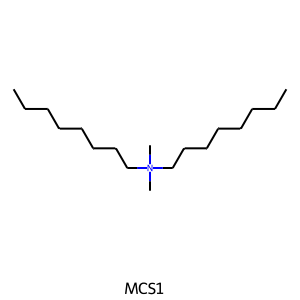

In [ ]:
mcs1 = rdFMCS.FindMCS([fda_compounds[i][0] for i in clusters[0][:]])
print(f'MCS1 contains {mcs1.numAtoms} atoms and {mcs1.numBonds} bonds.')
print('MCS SMARTS string:', mcs1.smartsString)
m1 = Chem.MolFromSmarts(mcs1.smartsString)
Draw.MolToImage(m1, legend = "MCS1")

MCS2 contains 46 atoms and 45 bonds.
MCS SMARTS string: [#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6](=[#8])-[#8]-[#6]-[#6](-[#6]-[#8]-[#15](=[#8])(-[#8])-[#8]-[#6]-[#6]-[#7](-[#6])(-[#6])-[#6])-[#8]-[#6](=[#8])-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]


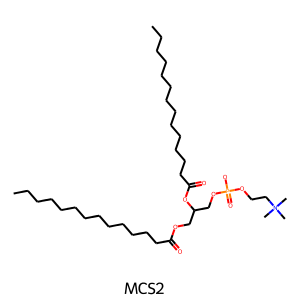

In [ ]:
mcs2 = rdFMCS.FindMCS([fda_compounds[i][0] for i in clusters[1][:]])
print(f'MCS2 contains {mcs2.numAtoms} atoms and {mcs2.numBonds} bonds.')
print('MCS SMARTS string:', mcs2.smartsString)
m2 = Chem.MolFromSmarts(mcs2.smartsString)
Draw.MolToImage(m2, legend = "MCS2")

In [ ]:
len(clusters)

2233

In [ ]:
# Número total de clusters
# num_clusters = len(clusters)
num_clusters = 15
mcs_list = []
# Bucle for para iterar sobre todos los clusters
for j in range(num_clusters):
    # En lugar de mcs2, usa una variable general mcs
    mcs = rdFMCS.FindMCS([fda_compounds[i][0] for i in clusters[j][:]])
    mcs_list.append({'MCS': f'MCS{j+1}', 'SMARTS': mcs.smartsString, 'frequency': int(len(clusters[j]))})
    print(f'MCS{j+1} contains {mcs.numAtoms} atoms and {mcs.numBonds} bonds.')
    print(f'MCS{j+1} SMARTS string:', mcs.smartsString)
    print(f'number of compounds with this MCS: {len(clusters[j])}')

mcs_df = pd.DataFrame(mcs_list)
print(mcs_df.head)


MCS1 contains 19 atoms and 18 bonds.
MCS1 SMARTS string: [#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#7](-[#6])(-[#6])-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]
number of compounds with this MCS: 3
MCS2 contains 46 atoms and 45 bonds.
MCS2 SMARTS string: [#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6](=[#8])-[#8]-[#6]-[#6](-[#6]-[#8]-[#15](=[#8])(-[#8])-[#8]-[#6]-[#6]-[#7](-[#6])(-[#6])-[#6])-[#8]-[#6](=[#8])-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]
number of compounds with this MCS: 3
MCS3 contains 14 atoms and 13 bonds.
MCS3 SMARTS string: [#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6](=[#8])-[#8]
number of compounds with this MCS: 3
MCS4 contains 20 atoms and 20 bonds.
MCS4 SMARTS string: [#8]-[#6](-[#6]-[#6]-[#7](-[#6]-[#6])-[#6]-[#6])(-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6](-[#6]-[#6])-[#6]-[#6]
number of compounds with this MCS: 3
MCS5 contains 45 atoms and 44 bonds.
MCS5 SMARTS string: [#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-

In [ ]:
PandasTools.AddMoleculeColumnToFrame(mcs_df, smilesCol='SMARTS')
mcs_df.columns

RDKit ERROR: [11:53:37] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [11:53:37] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [11:53:37] Explicit valence for atom # 1 N, 4, is greater than permitted
[11:53:37] Explicit valence for atom # 8 N, 4, is greater than permitted
[11:53:37] Explicit valence for atom # 26 N, 4, is greater than permitted
[11:53:37] Explicit valence for atom # 1 N, 4, is greater than permitted


Index(['MCS', 'SMARTS', 'frequency', 'ROMol'], dtype='object')

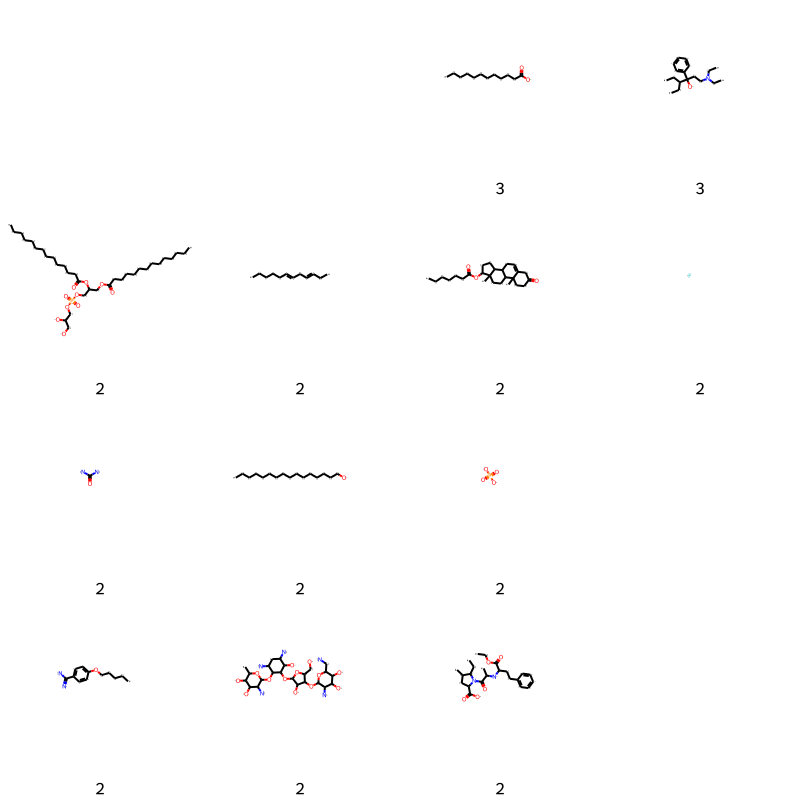

In [ ]:
PandasTools.FrameToGridImage(mcs_df[0:30], column='ROMol', legendsCol='frequency', molsPerRow=4)


In [ ]:
mcs_df.to_csv('fda_mcs.csv', index = False)